In [286]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import johnsonsu

from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from mlxtend.regressor import StackingCVRegressor


from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, RepeatedKFold, cross_val_score



In [170]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [171]:
print("Training data has", train.shape[0], "instances, and", train.shape[1], "features")
print("Testing data has", test.shape[0], "instances, and", test.shape[1], "features")

Training data has 1460 instances, and 81 features
Testing data has 1459 instances, and 80 features


### Exploring Target Variable = SalePrice

In [172]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [173]:
def plot_distributions(column):
    fig, axes = plt.subplots(1, 6, figsize=(30, 6), sharey=True)

    distributions = {
        'Normal': stats.norm,
        'Johnson SU': stats.johnsonsu,
        'Log-Normal': stats.lognorm,
        'Exponential': stats.expon,
        'Gamma': stats.gamma,
        'Weibull': stats.weibull_min
    }

    x = np.linspace(min(column), max(column), 100)
    for ax, (name, distribution) in zip(axes, distributions.items()):
        params = distribution.fit(column)
        p = distribution.pdf(x, *params)
        sns.histplot(column, kde=False, color='blue', stat='density', bins=30, ax=ax)
        ax.plot(x, p, 'k', linewidth=2, label=name)
        ax.legend()
        ax.set_title(f'{name} Distribution')

    plt.tight_layout()
    plt.show()


In [174]:
def best_fit_distribution(column):
    # Remove NaN values for fitting
    column = column.dropna()

    # List of distributions to check
    distributions = {
        'Normal': stats.norm,
        'Johnson SU': stats.johnsonsu,
        'Log-Normal': stats.lognorm,
        'Exponential': stats.expon,
        'Gamma': stats.gamma,
        'Weibull': stats.weibull_min
    }

    best_fit = None
    best_log_likelihood = -np.inf

    for name, distribution in distributions.items():
        try:
            # Fit the distribution to the data
            params = distribution.fit(column)
            # Calculate the log-likelihood
            log_likelihood = np.sum(distribution.logpdf(column, *params))
            # Update the best fit distribution if log-likelihood is better
            if log_likelihood > best_log_likelihood:
                best_log_likelihood = log_likelihood
                best_fit = name
        except Exception as e:
            print(f"Could not fit distribution {name}: {e}")

    return best_fit

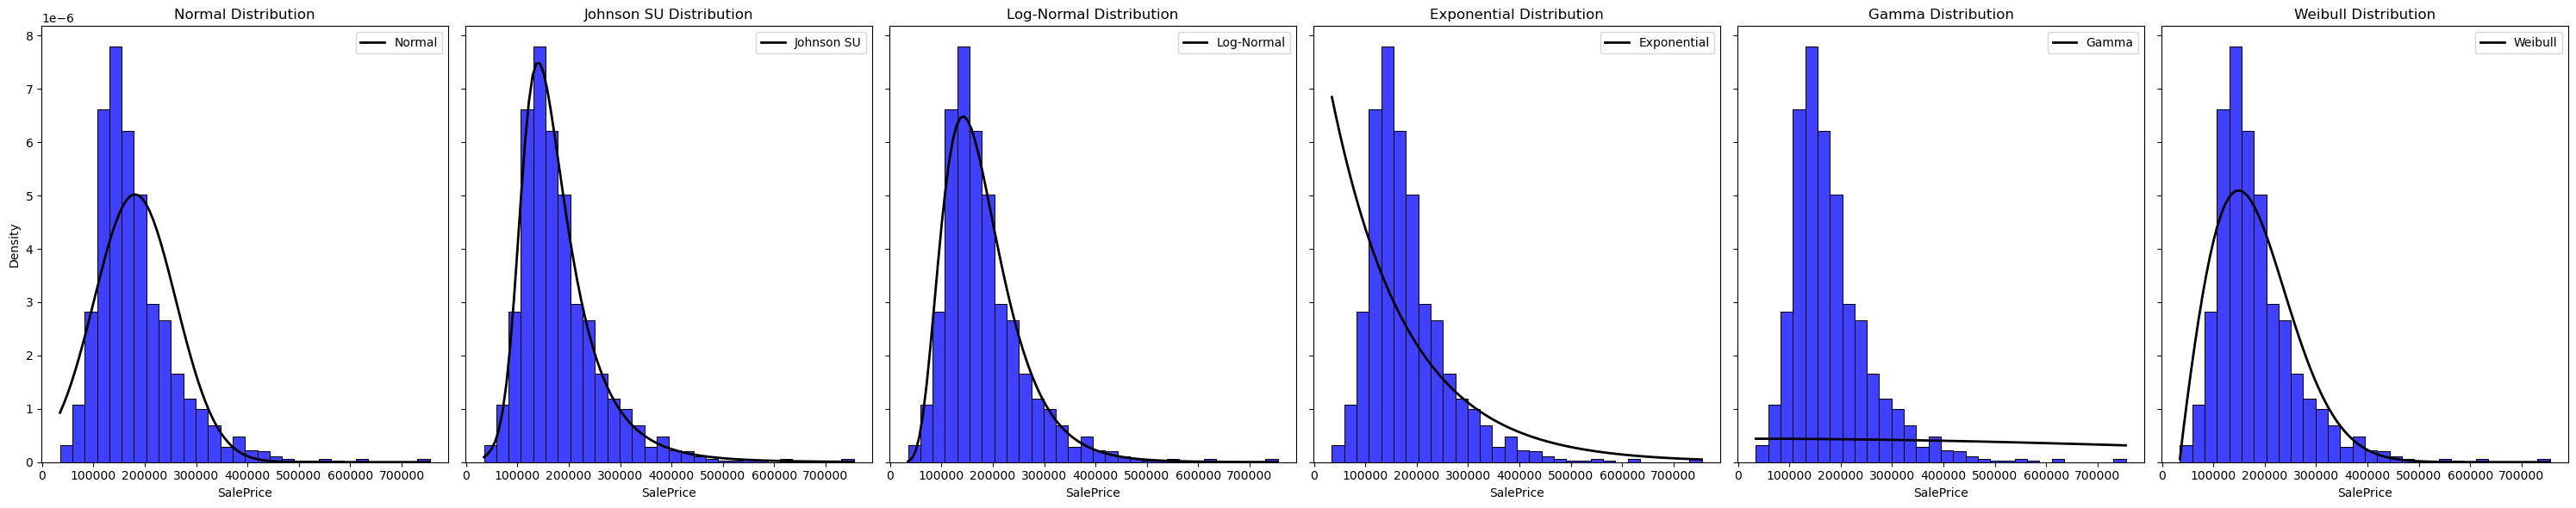

The best fitting distribution is: Johnson SU


In [175]:
plot_distributions(train['SalePrice'])
best_fit = best_fit_distribution(train['SalePrice'])
print(f'The best fitting distribution is: {best_fit}')


((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000], dtype=int64)),
 (74160.16474519415, 180921.19589041095, 0.9319665641512989))

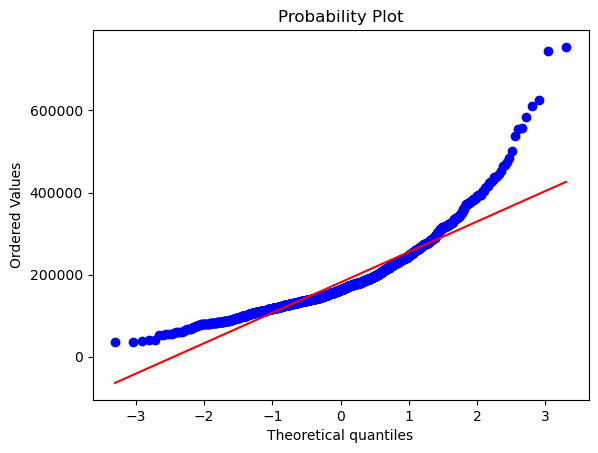

In [176]:
stats.probplot(train['SalePrice'], plot=plt)

Johnson SU distribution is the best fit for the SalePrice distribution. It is not normally distributed and will have to be transformed before we train the model and make predictions.

In [177]:
gamma, delta, xi, lam = johnsonsu.fit(train['SalePrice'])
transformed_data = np.log1p(train["SalePrice"])

# Add transformed and standardized data to the DataFrame for comparison
SalePrice = transformed_data


In [178]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(transformed_data)
normal = normal.apply(test_normality)
print(not normal.any())


False


((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([10.46027076, 10.47197813, 10.54273278, ..., 13.34550853,
         13.52114084, 13.53447435])),
 (0.398259646654151, 12.024057394918403, 0.9953761551826705))

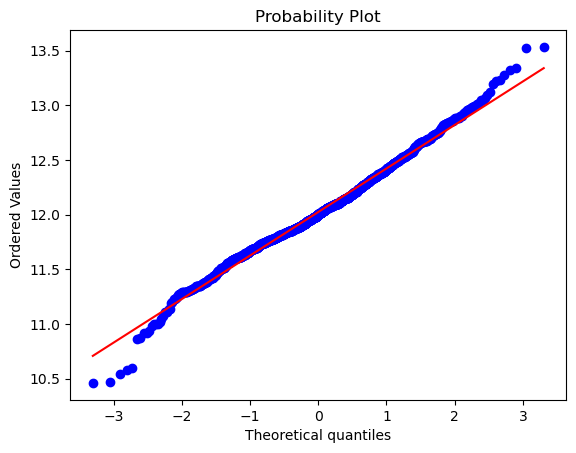

In [179]:
stats.probplot(SalePrice, plot=plt)

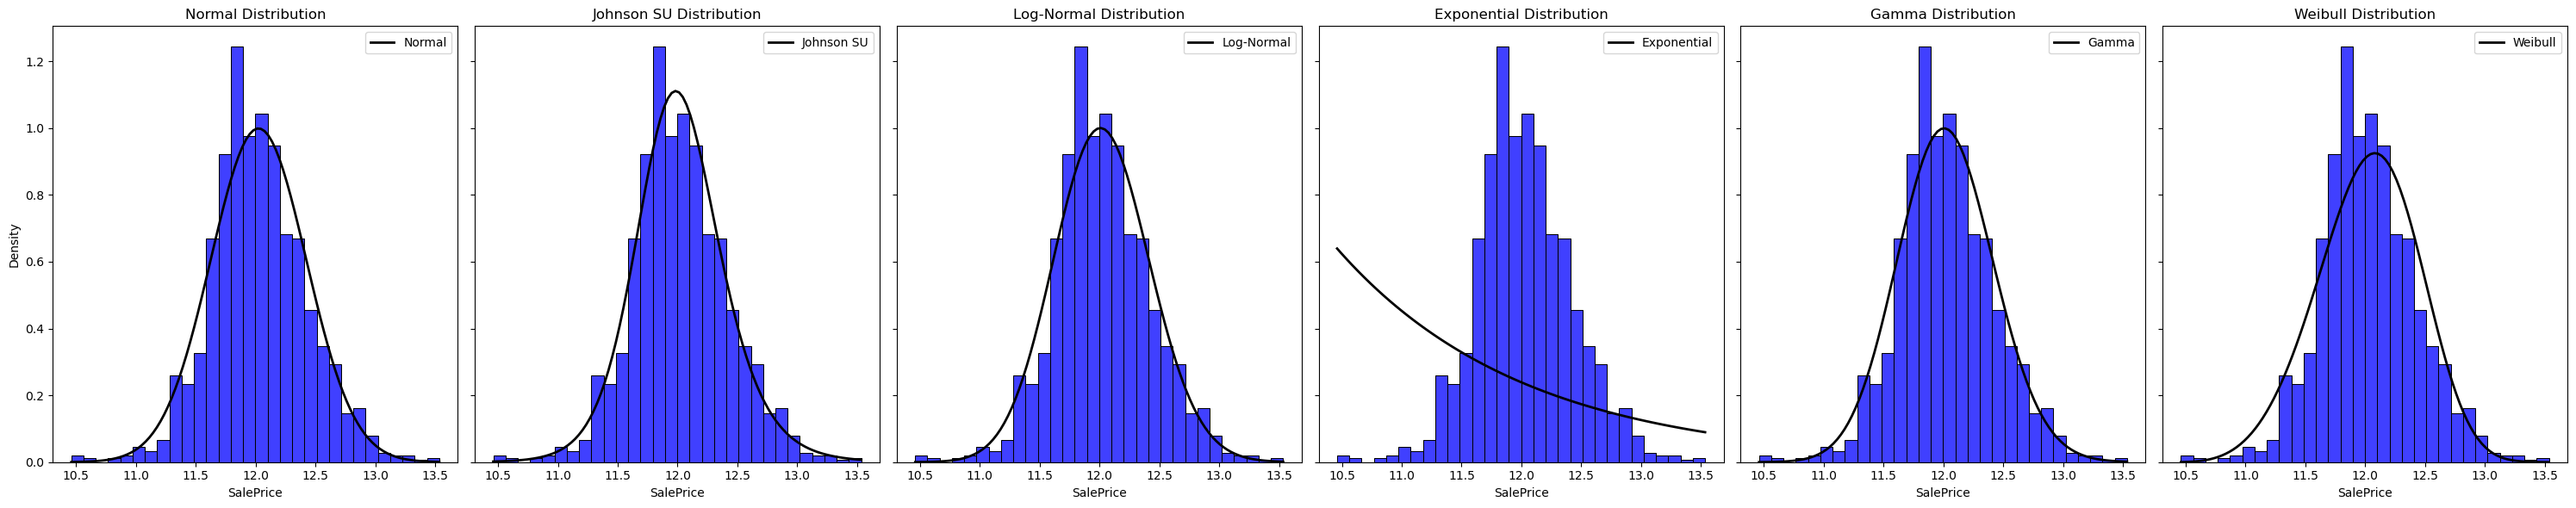

In [180]:
plot_distributions(SalePrice)

In [182]:
train_ID = train['Id']
test_ID = test['Id']

train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

train_features = train.drop(['SalePrice'], axis=1)
test_features = test

df = pd.concat([train_features, test_features]).reset_index(drop=True)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


Before checking if the the quantitive variables are normally distibuted or will have to be transformed, we will handle the missing values.  

### Handling missing values

Text(0.5, 1.0, 'Percent missing data by feature')

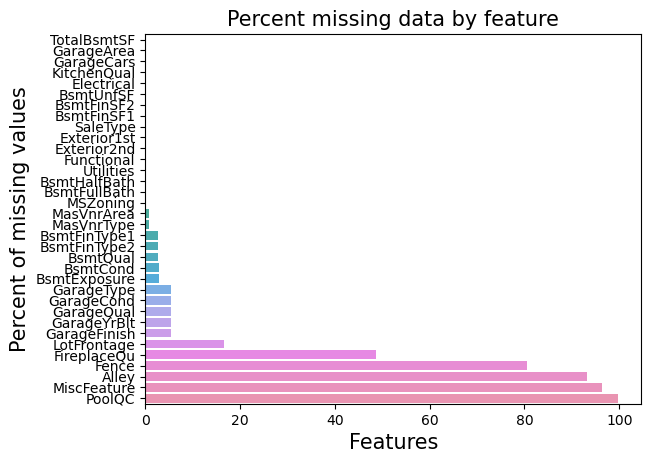

In [183]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
f, ax = plt.subplots()
sns.barplot(x=missing.values / len(df) * 100, y=missing.index)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [184]:
missing_data = pd.DataFrame({
    'Variable': missing.index,
    'Missing': missing.values,
    'Percent': missing.values / len(df) * 100
})
missing_data

,Variable,Missing,Percent
0,TotalBsmtSF,1,0.034258
1,GarageArea,1,0.034258
2,GarageCars,1,0.034258
3,KitchenQual,1,0.034258
4,Electrical,1,0.034258
5,BsmtUnfSF,1,0.034258
6,BsmtFinSF2,1,0.034258
7,BsmtFinSF1,1,0.034258
8,SaleType,1,0.034258
9,Exterior1st,1,0.034258


For 'PoolQC', 'MiscFeature', 'Alley', 'Fence', and 'FireplaceQu' missing values means None exist, hence we can impute it with "None"

In [185]:
df[['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']] = df[['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']].fillna('None')

'LotFrontage' is the linear feet of street connected to property. We can assume its about the same -> we'll impute with the median 


In [186]:
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())


For the missing values about a garage, we assume that missing values suggest that there is no garage. Hence we will fill the missing values with 0's and 'None'

In [187]:
df[['GarageType', 'GarageFinish', 'GarageCond', 'GarageQual']] = df[['GarageType', 'GarageFinish', 'GarageCond', 'GarageQual']].fillna('None')
df[['GarageYrBlt', 'GarageArea', 'GarageCars']] = df[['GarageYrBlt', 'GarageArea', 'GarageCars']].fillna(0)

We approach missing data about basements the same as with missing garage values.

In [188]:
df[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']] = df[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].fillna('None')
df[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']] = df[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']].fillna(0)


'MasVnrType' and 'MasVnrArea' refer to masonry veneer, we can assume that missing values are none existing masonry veneers

In [189]:
df['MasVnrType'] = df['MasVnrType'].fillna('None')
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

'Functional' describes says to "Assume typical unless deductions are warranted"

In [190]:
df['Functional'] = df['Functional'].fillna('Typ')

'MSZoning' identifies the general zoning classification of the sale. As we only have 4 instances missing, we will assume the mode.

We will do the same for the 'Utilities', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', and 'SaleType' columns

In [191]:
for col in ['MSZoning', 'Utilities', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

Lastly, 'MSSubClass' missing value suggest no class, fill with 'None'.

In [192]:
df['MSSubClass'] = df['MSSubClass'].fillna('None')


In [193]:
remain_missing = df.isnull().sum()
remain_missing = remain_missing[remain_missing > 0]
remain_missing

Series([], dtype: int64)

We have now dealt with all the missing values. We can move to

### Feature Engineering

We will focus on 3 different areas:

- Addressing wrong types (MSSubClass is an int, but in actually it represent categories: "type of dwelling involved in the sale")
- Creating new variables from existing ones- "Total Bathroom" from 4 different variables representing bathrooms...
- Encoding categorical variables and engineering numerical variables based on needs and distributions. 
  

In [194]:
df['MSSubClass'] = df['MSSubClass'].apply(str)

In [195]:
df['TotalBathrooms'] = df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath'])
df['HomeQual'] = df['OverallQual'] + df['OverallCond']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['PropertyAge'] = df['YrSold'] - df['YearBuilt']
df['Total_porch_sf'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])
df['Remodeled'] = df.apply(lambda x: 0 if x['YearBuilt'] == x['YearRemodAdd'] else 1, axis=1)
df['NewProperty'] = df['PropertyAge'].apply(lambda x: 1 if x == 0 else 0)
df['Haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['Has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df['Hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['Hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['Hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [196]:
df['YrSold'] = df['YrSold'].apply(str)
df['MoSold'] = df['MoSold'].apply(str)

In [197]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = [i for i in df.columns if df[i].dtype in numeric_dtypes]


In [198]:
for col in numerics:
    if np.isinf(df[col]).sum() > 0:
        print(f"Column {col} contains infinite values.")


In [132]:
skew_threshold = 0.5
skew_features = df[numerics].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
high_skew = skew_features[np.abs(skew_features) > skew_threshold]
print("Highly skewed features:\n", high_skew)


Highly skewed features:
 PoolArea         14.921454
Haspool          14.884318
3SsnPorch         8.754728
LowQualFinSF      8.431344
MiscVal           5.081024
NewProperty       4.712237
BsmtHalfBath      3.749219
ScreenPorch       2.925237
KitchenAbvGr      2.873749
BsmtFinSF2        2.393861
EnclosedPorch     1.912295
HalfBath          0.561935
PropertyAge      -0.574219
YearBuilt        -0.626215
BsmtFinSF1       -0.713412
LotArea          -0.893452
LotFrontage      -1.379506
OverallCond      -1.690363
BsmtUnfSF        -2.687404
GarageYrBlt      -3.925907
Hasgarage        -3.941054
TotalBsmtSF      -5.563824
Hasbsmt          -5.828995
dtype: float64


In [200]:
for col in high_skew.index:
    if df[col].min() > 0:
        df[col] = np.log1p(df[col])
    else:
        df[col] = np.log1p(df[col] - df[col].min() + 1)


In [201]:
scaler = StandardScaler()
df[numerics] = scaler.fit_transform(df[numerics])

In [202]:
# Check skewness after transformations
for col in numerics:
    print(f"{col} skewness after transformation is {stats.skew(df[col])}")


LotFrontage skewness after transformation is -0.9943302724007463
LotArea skewness after transformation is -0.5047505512989117
OverallQual skewness after transformation is 0.19711044867062394
OverallCond skewness after transformation is -0.7461828792022634
YearBuilt skewness after transformation is -0.626215388882427
YearRemodAdd skewness after transformation is -0.4510203770788587
MasVnrArea skewness after transformation is 2.6135921295017988
BsmtFinSF1 skewness after transformation is -0.5843096712453973
BsmtFinSF2 skewness after transformation is 2.4890129359366173
BsmtUnfSF skewness after transformation is -1.9989043912689637
TotalBsmtSF skewness after transformation is -4.785449062591135
1stFlrSF skewness after transformation is 1.4696044169256823
2ndFlrSF skewness after transformation is 0.8616747488436026
LowQualFinSF skewness after transformation is 8.608625284257561
GrLivArea skewness after transformation is 1.2693576882303348
BsmtFullBath skewness after transformation is 0.624

In [203]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
df_encoded = pd.get_dummies(df, columns=cat_cols, prefix=cat_cols)

In [204]:
X = df_encoded.iloc[:len(SalePrice), :]
test = df_encoded.iloc[len(SalePrice):, :]

In [205]:
print("training df shape:", X.shape)
print("SalePrice shape:", SalePrice.shape)
print("test df shape:", test.shape)

training df shape: (1460, 344)
SalePrice shape: (1460,)
test df shape: (1459, 344)


### Training the model

In [287]:
import shap
import xgboost as xgb
from catboost import Pool
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error


In [232]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, SalePrice,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)



In [278]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

In [279]:
# setup models    
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

# ridge = make_pipeline(RobustScaler(),
#                       RidgeCV(alphas=alphas_alt, cv=kfolds))

# lasso = make_pipeline(RobustScaler(),
#                       LassoCV(max_iter=10000000, alphas=alphas2,
#                               random_state=42, cv=kfolds))

# elasticnet = make_pipeline(RobustScaler(),
#                            ElasticNetCV(max_iter=10000000, alphas=e_alphas,
#                                         cv=kfolds, l1_ratio=e_l1ratio))
                                        
# svr = make_pipeline(RobustScaler(),
#                       SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


# gbr = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.01,
#                                    max_depth=4, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10, 
#                                    loss='huber', random_state =42)
                                   

# lightgbm = LGBMRegressor(objective='regression', 
#                          num_leaves=4,
#                          learning_rate=0.01, 
#                          n_estimators=5000,
#                          max_bin=200, 
#                          subsample=0.75,
#                          subsample_freq=5, 
#                          subsample_seed=7,
#                          feature_fraction=0.2,
#                          feature_fraction_seed=7,
#                          verbose=-1)


# xgboost = XGBRegressor(learning_rate=0.01, n_estimators=5000,
#                                      max_depth=3, min_child_weight=0,
#                                      gamma=0, subsample=0.7,
#                                      colsample_bytree=0.7,
#                                      objective='reg:squarederror', nthread=-1,
#                                      scale_pos_weight=1, seed=27,
#                                      reg_alpha=0.00006)

# # stack
# stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
#                                             gbr, xgboost, lightgbm),
#                                 meta_regressor=xgboost,
#                                 use_features_in_secondary=True)


In [288]:
models = {
    'Ridge Regression': make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds)),
    'Lasso Regression': make_pipeline(RobustScaler(), LassoCV(max_iter=10000000, alphas=alphas2, random_state=42, cv=kfolds)),
    'ElasticNet Regression': make_pipeline(RobustScaler(), ElasticNetCV(max_iter= 10000000, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio)),
    'SVR': make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.0075, gamma=0.0005)),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state=42),
    'LightGBM Regressor': LGBMRegressor(objective='regression', num_leaves=4, learning_rate=0.01, n_estimators=5000, max_bin=200, subsample=0.65, subsample_freq=5, subsample_seed=42, feature_fraction=0.5, feature_fraction_seed=42, verbose=-1),
    'XGBoost Regressor': XGBRegressor(learning_rate=0.01, n_estimators=5000, max_depth=3, min_child_weight=0, gamma=0, subsample=0.75, colsample_bytree=0.75, objective='reg:squarederror', nthread=-1, scale_pos_weight=1, seed=42, reg_alpha=0.0001),
    'KNeighbors Regressor': KNeighborsRegressor(n_neighbors=6),
    'AdaBoost Regressor': AdaBoostRegressor(n_estimators=100, random_state=42)
}


In [283]:
# Calculate CV RMSE for each model
cv_scores = []
cv_std = []

for name, model in models.items():
    score = cv_rmse(model)
    cv_scores.append(score.mean())
    cv_std.append(score.std())
    print(f"{name}: Mean RMSE = {score.mean()}, Std RMSE = {score.std()}")

# Create a DataFrame to store the results
final_cv_score = pd.DataFrame(list(models.keys()), columns=['Regressors'])
final_cv_score['RMSE_mean'] = cv_scores
final_cv_score['RMSE_std'] = cv_std

print(final_cv_score)

Ridge Regression: Mean RMSE = 0.13220725375409276, Std RMSE = 0.031643574597057376
Lasso Regression: Mean RMSE = 0.12847374538153453, Std RMSE = 0.03543510912663632
ElasticNet Regression: Mean RMSE = 0.12808847865374864, Std RMSE = 0.03457246475012436
SVR: Mean RMSE = 0.12777163726935337, Std RMSE = 0.031206177062278136
Gradient Boosting Regressor: Mean RMSE = 0.12031255528455609, Std RMSE = 0.02241514156886015
[LightGBM] [Warning] Unknown parameter: subsample_seed
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] Unknown parameter: subsample_seed
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] Unknown parameter: subsample_seed
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] Unknown parameter: subsampl

In [284]:
# Add the stacking regressor
stack_gen = StackingCVRegressor(
    regressors=(
        models['Ridge Regression'],
        models['Lasso Regression'],
        models['ElasticNet Regression'],
        models['Gradient Boosting Regressor'],
        models['LightGBM Regressor'],
        models['XGBoost Regressor'],
        models['KNeighbors Regressor'],
        models['AdaBoost Regressor']
    ),
    meta_regressor=models['XGBoost Regressor'],
    use_features_in_secondary=True
)

models['Stacked Regressor'] = stack_gen


In [285]:
print('START Fit')

# StackingCVRegressor
print('StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(X), np.array(SalePrice))

# ElasticNet
print('ElasticNet')
elastic_model_full_data = elasticnet.fit(X, SalePrice)

# Lasso
print('Lasso')
lasso_model_full_data = lasso.fit(X, SalePrice)

# Ridge
print('Ridge')
ridge_model_full_data = ridge.fit(X, SalePrice)

# SVR
print('SVR')
svr_model_full_data = svr.fit(X, SalePrice)

# GradientBoosting
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, SalePrice)

# XGBoost
print('XGBoost')
xgb_model_full_data = xgboost.fit(X, SalePrice)

# LightGBM
print('LightGBM')
lgb_model_full_data = lightgbm.fit(X, SalePrice)

# AdaBoostRegressor
print('AdaBoostRegressor')
ada_model_full_data = ada.fit(X, SalePrice)

print('All models fitted successfully')


START Fit
StackingCVRegressor
[LightGBM] [Warning] Unknown parameter: subsample_seed
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] Unknown parameter: subsample_seed
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] Unknown parameter: subsample_seed
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] Unknown parameter: subsample_seed
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] Unknown parameter: subsample_seed
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] Unknown parameter: subsample_seed
[LightGBM] [Warning]

NameError: name 'knn' is not defined

In [253]:
def blend_models_predict(X):
    return ((0.05 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.05 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.15 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.15 * lgb_model_full_data.predict(X)) + \
            (0.025 * knn_model_full_data.predict(X)) + \
            (0.025 * ada_model_full_data.predict(X)) + \
            (0.25 * stack_gen_model.predict(np.array(X))))

            
print('RMSLE score on train data:')
prediced_saleprice = blend_models_predict(test)
print(rmsle(SalePrice, blend_models_predict(X)))


RMSLE score on train data:
0.06733059848769087


In [258]:
submission = pd.DataFrame({'SalePrice':np.expm1(prediced_saleprice)}, index=test_ID)
submission.to_csv('blended_regression.csv')

In [259]:
submission

,SalePrice
Id,
1461,123705.249359
1462,158345.133719
1463,185321.595238
1464,198766.489016
1465,187462.868981
...,...
2915,84342.496546
2916,82407.715811
2917,166723.268917
